# Importation des librairies nécessaires

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# SCIKIT-LEARN: SELECTION DE VARIABLES

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.ensemble import RandomForestClassifier

# SCIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 
from sklearn_pandas import DataFrameMapper

# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, roc_curve, auc

# SMOTE
from imblearn.over_sampling import SMOTE

# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparer en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation : visulaisr des scores lors du choix d'un hyper-paramètre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper-paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage : visualisation des scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEURll
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# YELLOWBRICK
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

# Importation des modules

In [2]:
# Configuration du chemin d'accès
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importations des modules nécessaires
import data_loader
import preprocessing
import modeling
import evaluation
import cleaning

# Chargement des données

In [3]:
def reduce_dataset(data_path, target_column, output_path, train_size=100000, random_state=42):
    """
    Réduit le dataset à un nombre spécifié de lignes tout en conservant les proportions des classes.
    
    Parameters:
    - data_path (str): Le chemin du fichier CSV à charger.
    - target_column (str): Le nom de la colonne cible pour le stratified sampling.
    - output_path (str): Le chemin du fichier CSV où sauvegarder le dataset réduit.
    - train_size (int): Le nombre de lignes du dataset réduit (par défaut 100 000).
    - random_state (int): La graine aléatoire pour la reproductibilité (par défaut 42).
    """
    # Charger les données
    df = pd.read_csv(data_path)
    
    # Réduire le dataset à la taille spécifiée en utilisant un échantillonnage stratifié
    df_reduced, _ = train_test_split(df, stratify=df[target_column], train_size=train_size, random_state=random_state)
    
    # Sauvegarder le nouveau dataset
    df_reduced.to_csv(output_path, index=False)
    
    # Vérifier la distribution des classes dans le nouvel ensemble de données
    distribution = df_reduced[target_column].value_counts(normalize=True)
    print("Distribution des classes dans le dataset réduit :")
    print(distribution)
    
    return df_reduced


In [4]:
data_path = '../data/smoking_driking_dataset_Ver01.csv'
target_column = 'SMK_stat_type_cd' 
output_path = '../data/reduced_smoking_drinking_dataset.csv'

# Réduire le dataset
reduced_df = reduce_dataset(data_path, target_column, output_path)

Distribution des classes dans le dataset réduit :
SMK_stat_type_cd
1.0    0.60770
3.0    0.21582
2.0    0.17648
Name: proportion, dtype: float64


# Nettoyage des données

## Type des variables

In [5]:
intToFloat = ['age', 'height', 'weight']
floatToInt = ['hear_left', 'hear_right', 'urine_protein', 'SMK_stat_type_cd']

In [6]:
cleaning.convertType(reduced_df, intToFloat, floatToInt)

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
715666,Male,35.0,170.0,55.0,76.0,1.2,1.5,1,1,110.0,...,139.0,101.0,14.8,1,0.7,23.0,16.0,10.0,3,Y
81495,Male,75.0,155.0,65.0,91.9,1.0,0.6,1,1,130.0,...,138.0,84.0,14.5,1,1.1,23.0,26.0,24.0,2,N
486414,Male,55.0,165.0,75.0,85.9,1.2,0.8,1,1,110.0,...,98.0,71.0,16.0,1,1.4,35.0,52.0,54.0,3,Y
288708,Male,40.0,170.0,70.0,83.0,1.2,1.2,1,1,123.0,...,122.0,72.0,14.8,1,1.0,26.0,24.0,14.0,1,N
291885,Male,60.0,160.0,75.0,98.0,1.0,1.0,1,1,114.0,...,94.0,183.0,13.7,1,1.1,20.0,11.0,19.0,2,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854699,Male,60.0,170.0,75.0,100.0,0.7,0.5,1,1,131.0,...,25.0,300.0,12.6,1,1.2,69.0,42.0,79.0,2,Y
470801,Male,45.0,165.0,65.0,79.0,0.6,0.8,1,1,130.0,...,133.0,198.0,16.3,1,0.9,20.0,27.0,87.0,3,Y
416453,Female,60.0,160.0,60.0,74.0,1.0,0.8,1,1,130.0,...,127.0,136.0,14.0,1,0.7,25.0,18.0,13.0,1,N
66667,Male,30.0,170.0,70.0,85.0,1.0,1.2,1,1,122.0,...,98.0,138.0,15.8,1,1.2,21.0,21.0,20.0,1,Y


In [7]:
reduced_df.dtypes

sex                  object
age                 float64
height              float64
weight              float64
waistline           float64
sight_left          float64
sight_right         float64
hear_left             int64
hear_right            int64
SBP                 float64
DBP                 float64
BLDS                float64
tot_chole           float64
HDL_chole           float64
LDL_chole           float64
triglyceride        float64
hemoglobin          float64
urine_protein         int64
serum_creatinine    float64
SGOT_AST            float64
SGOT_ALT            float64
gamma_GTP           float64
SMK_stat_type_cd      int64
DRK_YN               object
dtype: object

In [8]:
cont_features = reduced_df.select_dtypes(include=['float64']).columns
cat_features = reduced_df.select_dtypes(include=['object', 'int64']).columns
cat_features = cat_features.drop(['SMK_stat_type_cd', 'DRK_YN'])

In [9]:
cont_features, cat_features

(Index(['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right',
        'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
        'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST',
        'SGOT_ALT', 'gamma_GTP'],
       dtype='object'),
 Index(['sex', 'hear_left', 'hear_right', 'urine_protein'], dtype='object'))

## Outliers

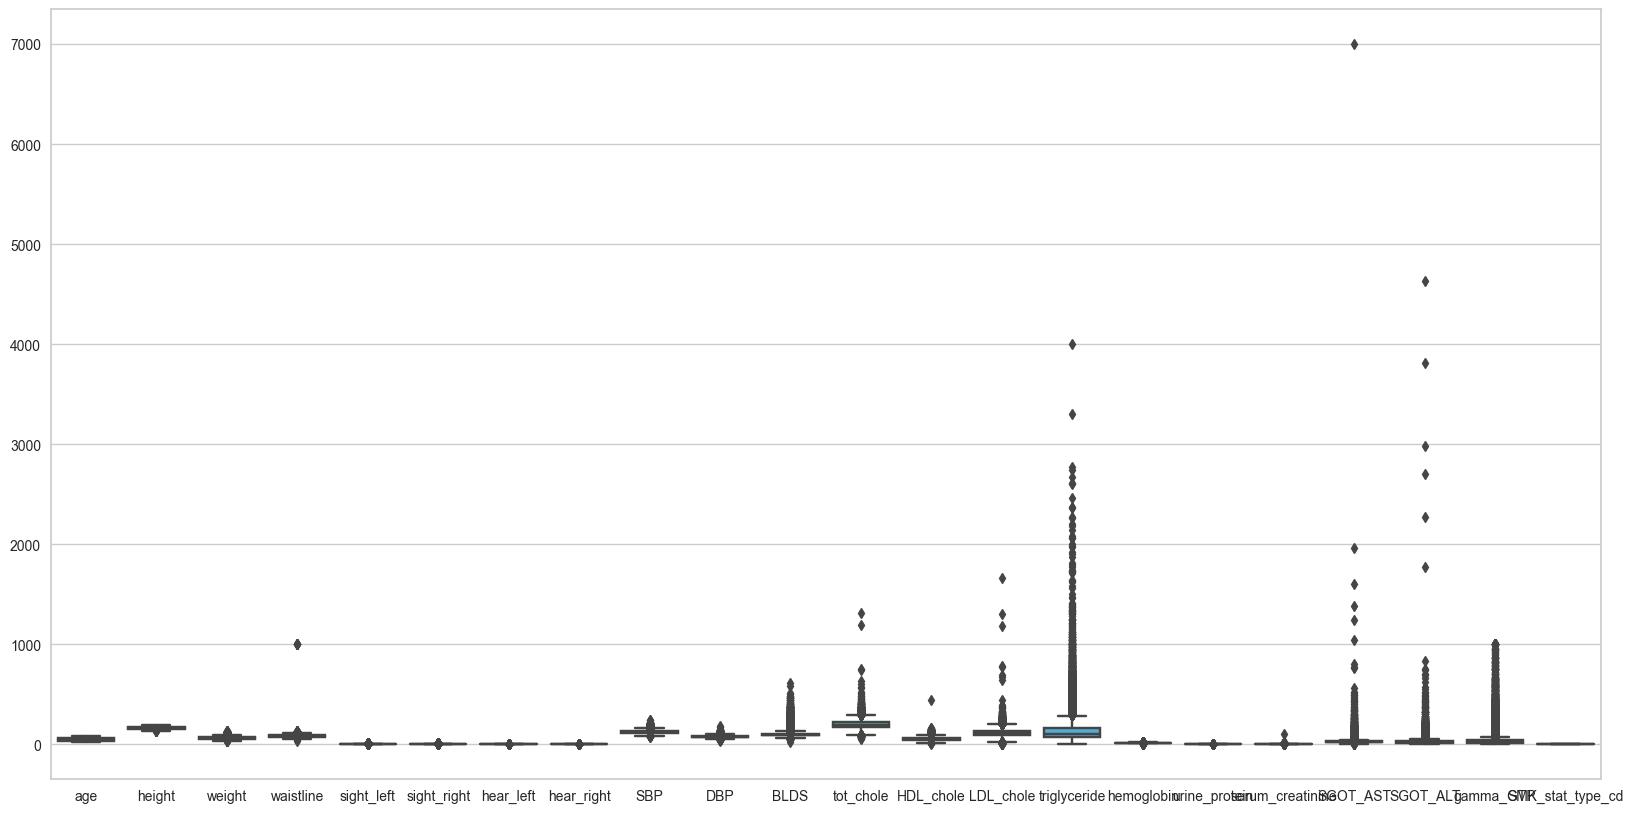

In [10]:
plt.figure(figsize=(20,10))
sns.boxplot(data=reduced_df)
plt.show()

In [11]:
col_limits = {
    'triglyceride': 3000,
    'LDL_chole': 3000,
    'HDL_chole': 3000,
    'SGOT_AST': 3000,
    'SGOT_ALT': 3000
}

# Filtrer les outliers
reduced_df = cleaning.filter_outliers(reduced_df, col_limits)

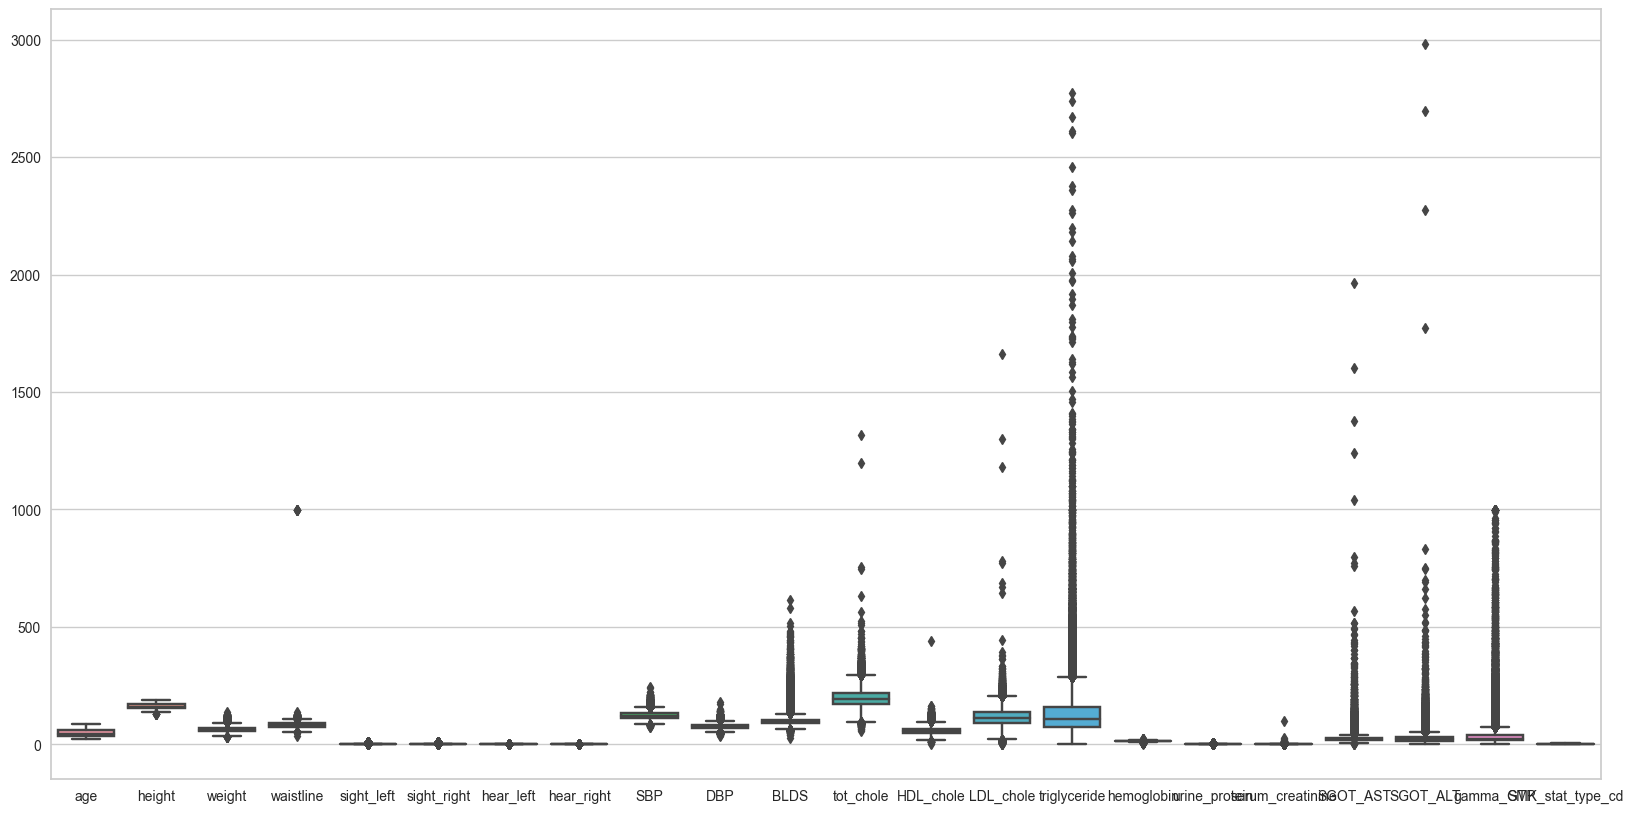

In [12]:
plt.figure(figsize=(20,10))
sns.boxplot(data=reduced_df)
plt.show()

# Séparation données train / test

In [14]:
X = reduced_df.drop(columns=['SMK_stat_type_cd', 'DRK_YN'])
y = reduced_df['SMK_stat_type_cd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
y_train.value_counts(), y_test.value_counts()

(SMK_stat_type_cd
 1    48615
 3    17263
 2    14118
 Name: count, dtype: int64,
 SMK_stat_type_cd
 1    12154
 3     4316
 2     3530
 Name: count, dtype: int64)

## Sélection de variables

### Validation croisée pour avoir la meilleure valeur de k features à retenir

Best k: 21
Best cross-validation score: 0.6799304716102949


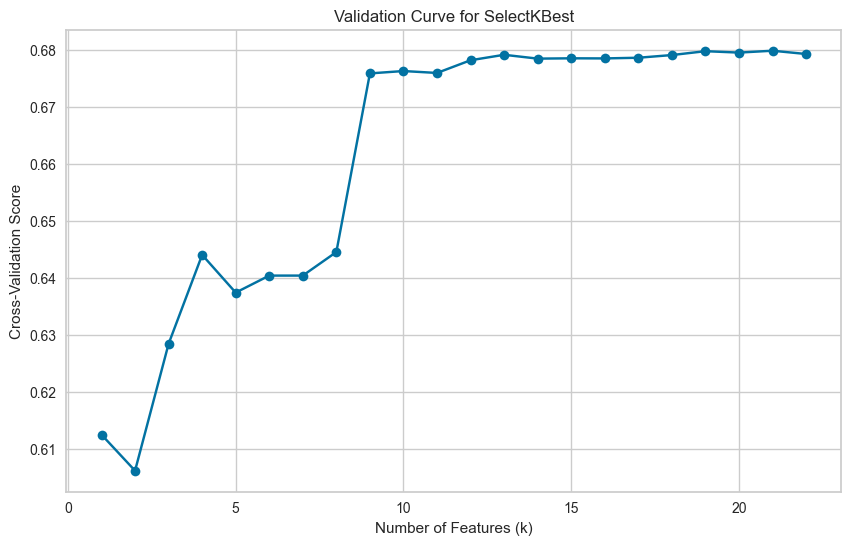

In [16]:
def preprocess_data(X_train, X_test, cont_features, cat_features):
    # Preprocess numerical features
    cont_preprocessor = make_pipeline(StandardScaler())
    
    # Preprocess categorical features
    cat_preprocessor = make_pipeline(OrdinalEncoder())
    
    preprocessor = make_column_transformer((cont_preprocessor, cont_features),
                                           (cat_preprocessor, cat_features),
                                           remainder='drop')
    
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    
    return X_train_prep, X_test_prep, preprocessor

def select_best_k(X_train, y_train, preprocessor, k_values):
    best_score = 0
    best_k = 0
    
    for k in k_values:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        
        model = LogisticRegression()
        scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='f1_weighted')
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            
    return best_k, best_score

def plot_validation_curve(X_train, y_train, preprocessor, k_values):
    scores = []
    
    for k in k_values:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        
        model = LogisticRegression()
        cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='f1_weighted')
        scores.append(np.mean(cv_scores))
        
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, scores, marker='o')
    plt.xlabel('Number of Features (k)')
    plt.ylabel('Cross-Validation Score')
    plt.title('Validation Curve for SelectKBest')
    plt.grid(True)
    plt.show()

# Prétraiter les données
X_train_prep, X_test_prep, preprocessor = preprocess_data(X_train, X_test, cont_features, cat_features)

# Définir les valeurs de k à tester
k_values = range(1, X_train_prep.shape[1] + 1)

# Sélectionner le meilleur k
best_k, best_score = select_best_k(X_train_prep, y_train, preprocessor, k_values)

print(f"Best k: {best_k}")
print(f"Best cross-validation score: {best_score}")

# Tracer la courbe de validation
plot_validation_curve(X_train_prep, y_train, preprocessor, k_values)

### Sélection

In [17]:
def preprocess_data(X_train, X_test, cont_features, cat_features, target, k):
    # Preprocess numerical features
    cont_preprocessor = make_pipeline(StandardScaler())
    
    # Preprocess categorical features
    cat_preprocessor = make_pipeline(OrdinalEncoder())
    
    preprocessor = make_column_transformer((cont_preprocessor, cont_features),
                                           (cat_preprocessor, cat_features),
                                           remainder='drop')
    
    # Fit and transform the training data
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    
    # SelectKBest to select the top k features
    selector = SelectKBest(score_func=f_classif, k=k)    
    X_train_selected = selector.fit_transform(X_train_prep, target)
    X_test_selected = selector.transform(X_test_prep)
    
    # Get the selected feature names
    selected_features = selector.get_support(indices=True)
    feature_names = preprocessor.get_feature_names_out()
    selected_feature_names = [feature_names[i] for i in selected_features]

    print("Selected feature names:", selected_feature_names)
    
    return X_train_selected, X_test_selected

In [20]:
# Nombre de caractéristiques à sélectionner
k = 10

X_train_prep, X_test_prep = preprocess_data(X_train, X_test, cont_features, cat_features, y_train, k)

Selected feature names: ['pipeline-1__age', 'pipeline-1__height', 'pipeline-1__weight', 'pipeline-1__waistline', 'pipeline-1__HDL_chole', 'pipeline-1__triglyceride', 'pipeline-1__hemoglobin', 'pipeline-1__serum_creatinine', 'pipeline-1__gamma_GTP', 'pipeline-2__sex']


# Prétraitement (inclus dans la sélection)

In [24]:
# def preprocess_data(X_train, X_test, cont_features, cat_features):
#     # Preprocess numerical features
#     cont_preprocessor = make_pipeline(StandardScaler())
    
#     # Preprocess categorical features
#     cat_preprocessor = make_pipeline(OrdinalEncoder())
    
#     preprocessor = make_column_transformer((cont_preprocessor, cont_features),
#                                             (cat_preprocessor, cat_features),
#                                             remainder='drop')
    
#     X_train_prep = preprocessor.fit_transform(X_train)
#     X_test_prep = preprocessor.transform(X_test)
    
#     return X_train_prep, X_test_prep

In [25]:
# X_train_prep, X_test_prep = preprocess_data(X_train, X_test, cont_features, cat_features)

# Modélisation

In [60]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap='Blues', figsize=(10, 7)):
    """
    Plots a confusion matrix using matplotlib.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        True labels.
    y_pred : array-like of shape (n_samples,)
        Predicted labels.
    classes : array-like of shape (n_classes,)
        List of class labels.
    cmap : str, default='Blues'
        Colormap for the heatmap.
    figsize : tuple, default=(10, 7)
        Figure size.
    """
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    
    # Créer une figure et un axe
    fig, ax = plt.subplots(figsize=figsize)
    
    # Créer une heatmap
    cax = ax.matshow(cm, cmap=cmap)
    
    # Ajouter une barre de couleur
    fig.colorbar(cax)
    
    # Annoter la heatmap avec les valeurs de la matrice de confusion
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')
    
    # Définir les labels des axes
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)
    
    # Définir les labels des axes et le titre
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    
    # Afficher la heatmap
    plt.show()

In [61]:
def evaluate_model_multiclass(y_true, y_pred, class_labels):
    """
    Evaluate a multi-class classification model using confusion matrix, classification metrics, 
    and ROC AUC.

    Args:
        y_true (array): True class labels.
        y_pred (array): Predicted class labels.
        class_labels (array): List of class labels.
    """
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=class_labels)

    # Calculate classification metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Display classification metrics
    print("*** Classification Metrics ***")
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)
    print("******************************")


    # Binarize the output
    y_onehot_test = label_binarize(y_true, classes=class_labels)
    y_score = label_binarize(y_pred, classes=class_labels)

    # ROC AUC for multi-class classification
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label='Class %d (AUC=%0.3f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Multi-class ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC scores for each class
    print("AUC scores for each class:", roc_auc)

    # Calculate micro-average ROC AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot micro-average ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (AUC = %0.3f)' % roc_auc["micro"], color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Micro-averaged ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Print micro-average ROC AUC
    print("Micro-average ROC AUC:", roc_auc["micro"])

    # Calculate average ROC AUC
    mean_auc = np.mean(list(roc_auc.values()))

    # Print average ROC AUC
    print("Mean ROC AUC:", mean_auc)

    # # Classification report
    # print("*** Classification Report ***")
    # print(classification_report(y_true, y_pred))

# Régression logistique 

In [46]:
# Modèles
logreg = LogisticRegression(penalty=None, tol=10e-6, random_state=42)
logregRidge = LogisticRegression(C=0.1, penalty='l2', tol=10e-6, random_state=42, solver='lbfgs')
logregLasso = LogisticRegression(C=0.1, penalty='l1', tol=10e-6, random_state=42, solver='saga')
logregElasticNet = LogisticRegression(C=0.1, penalty='elasticnet', l1_ratio=0.7, tol=10e-6, random_state=42, solver='saga')

In [62]:
# Créer et entraîner un modèle de régression logistique

logreg.fit(X_train_prep, y_train)

LogisticRegression(penalty=None, random_state=42, tol=1e-05)

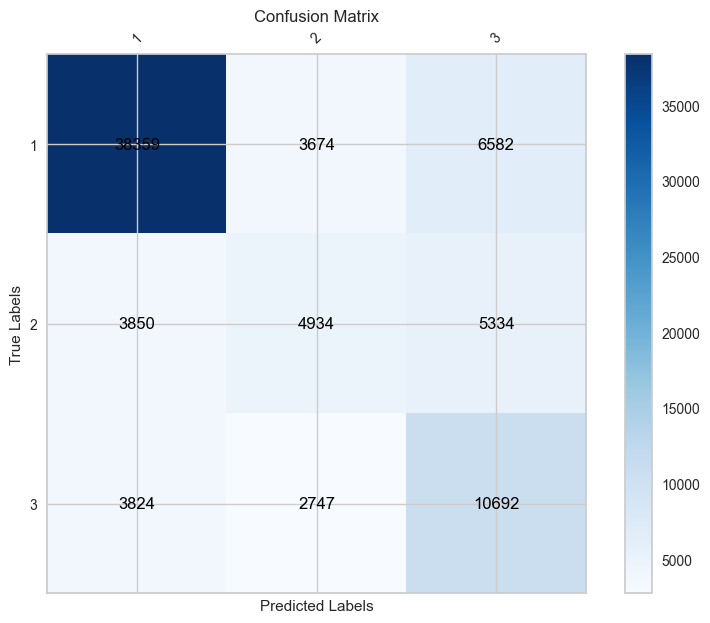

*** Classification Metrics ***
Precision = 0.6851509858698066
Recall = 0.6748462423121157
F1 Score = 0.6766997550594015
******************************


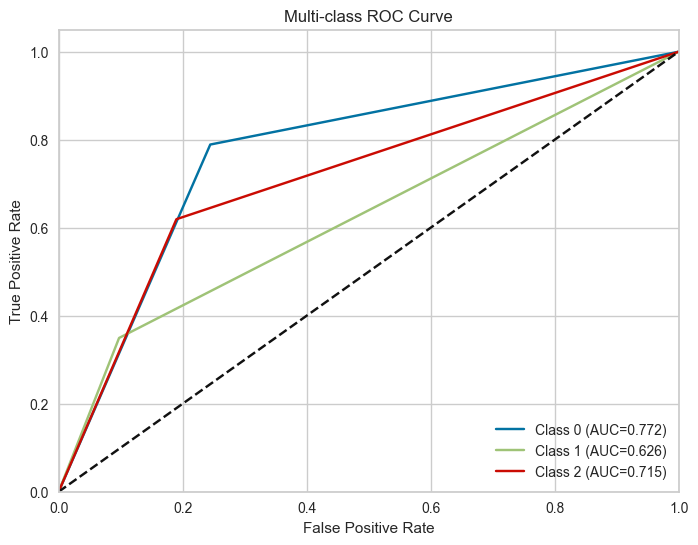

AUC scores for each class: {0: 0.7722467147021341, 1: 0.6260074412987323, 2: 0.7147057245419638}


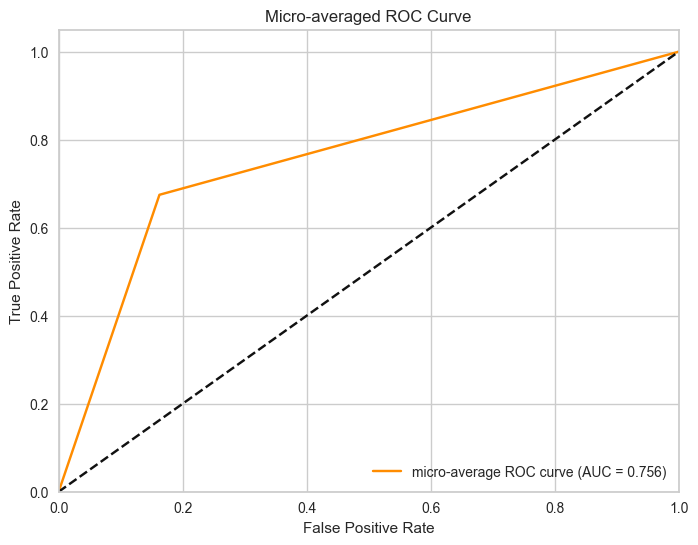

Micro-average ROC AUC: 0.7561346817340867
Mean ROC AUC: 0.7172736405692293


In [63]:
# Evaluer le modèle sur les données train
y_train_pred = logreg.predict(X_train_prep)
evaluate_model_multiclass(y_train, y_train_pred, logreg.classes_)

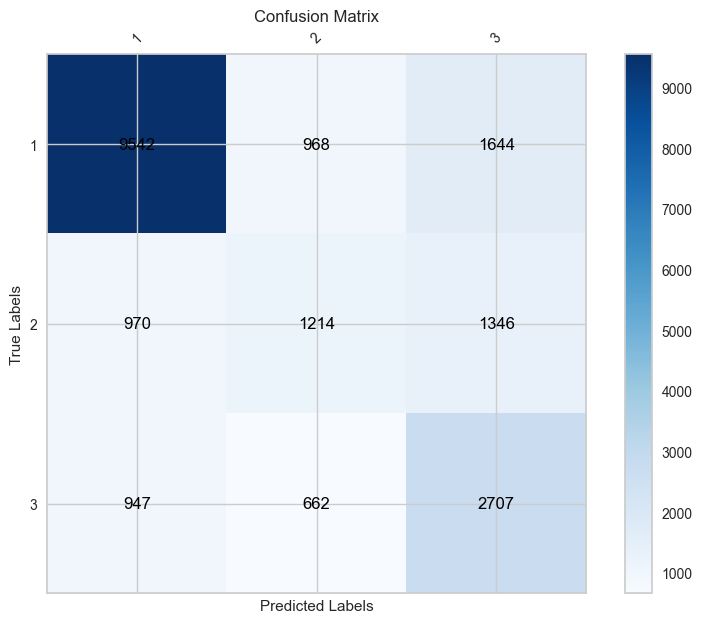

*** Classification Metrics ***
Precision = 0.6839180592036349
Recall = 0.67315
F1 Score = 0.6750577090990475
******************************


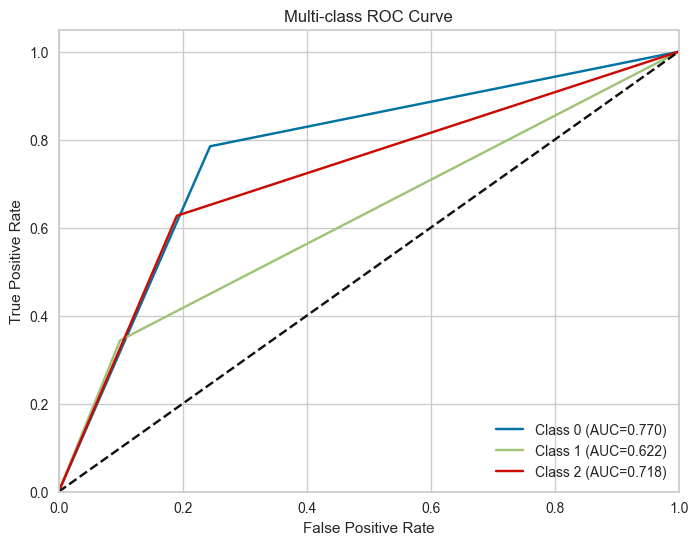

AUC scores for each class: {0: 0.7703815038973668, 1: 0.6224707640813153, 2: 0.7182804846600811}


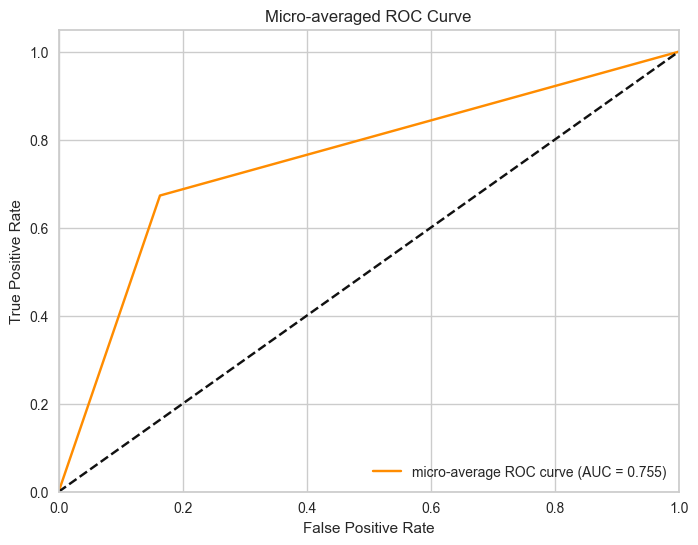

Micro-average ROC AUC: 0.7548625000000001
Mean ROC AUC: 0.7164988131596909


In [49]:
# Evaluer le modèle sur les données test
y_test_pred = logreg.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred, logreg.classes_)

<font color='red'>**Commentaire**</font> 

La classe 2 a le plus mauvais score entre les trois. C'est aussi la classe la moins représentée. Nous allons tenter un sur-échantillonnage pour améliorer les résultats. 

### Sur échantillonnage

In [50]:
# Suréchantillonnage des données avec SMOTE
smote = SMOTE(random_state=42)
X_train_up, y_train_up = smote.fit_resample(X_train_prep, y_train)

In [51]:
# Ajuster le modèle de régression logistique sur les données suréchantillonnées
logreg_up = LogisticRegression(penalty=None, tol=10e-6, random_state=42)
logreg_up.fit(X_train_up, y_train_up)

LogisticRegression(penalty=None, random_state=42, tol=1e-05)

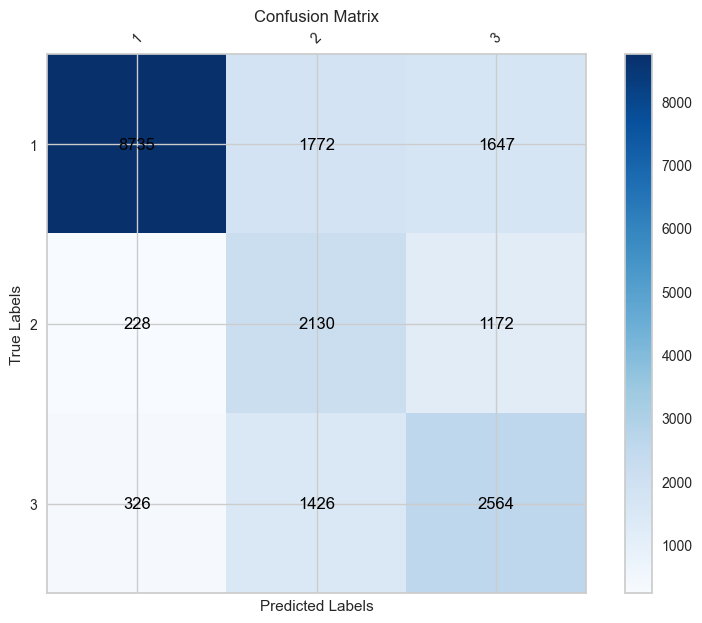

*** Classification Metrics ***
Precision = 0.7448053863200009
Recall = 0.67145
F1 Score = 0.6940833212262222
******************************


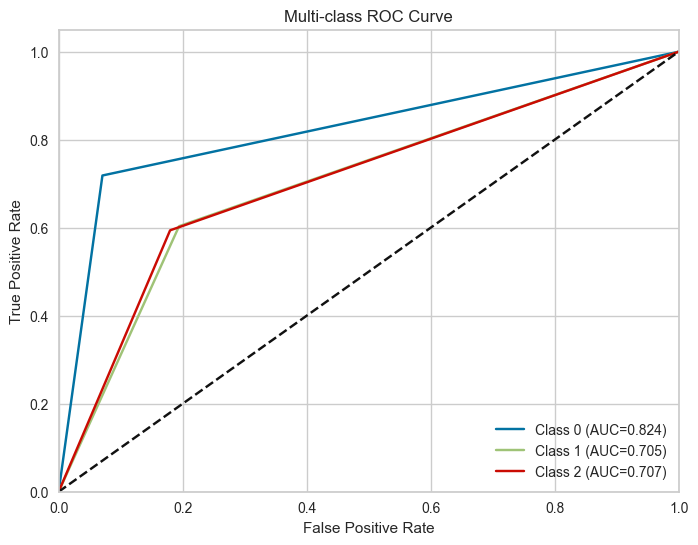

AUC scores for each class: {0: 0.8240421033142058, 1: 0.7046141065135167, 2: 0.7071656350550811}


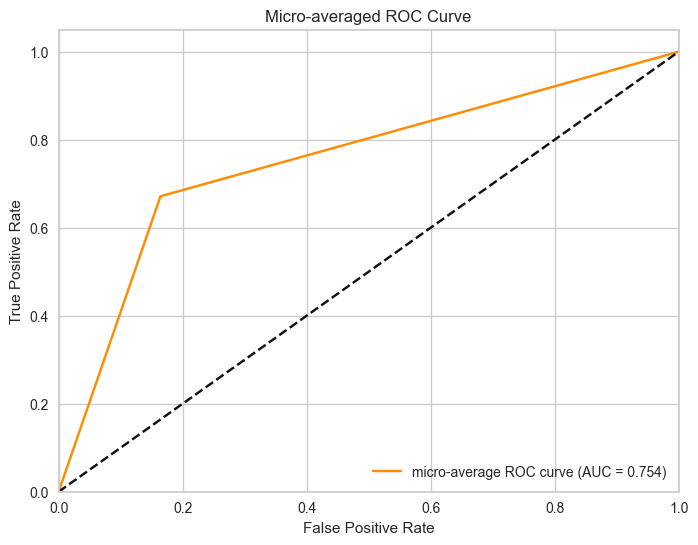

Micro-average ROC AUC: 0.7535875000000001
Mean ROC AUC: 0.747352336220701


In [52]:
# Prédiction sur les données test et évaluation
y_test_pred_up = logreg_up.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred_up, logreg_up.classes_)

<font color='red'>**Commentaire**</font> 

Le SMOTE a amélioré la précision de 0,06 et le score F1 (qui nous intéresse surtout ici) a légèrement augmenté également (+0,02). Voyons si l'ajout d'une pénalité améliore les résultats.

### Sous échantillonnage

In [53]:
# Sous-échantillonnage des données avec NearMiss
from imblearn.under_sampling import NearMiss

# Sous-échantillonnage des données avec NearMiss
nm = NearMiss(version=1)
X_train_down, y_train_down = nm.fit_resample(X_train_prep, y_train)

In [54]:
logreg_down = LogisticRegression(penalty=None, solver='saga', tol=10e-6, random_state=42)
logreg_down.fit(X_train_down, y_train_down)

LogisticRegression(penalty=None, random_state=42, solver='saga', tol=1e-05)

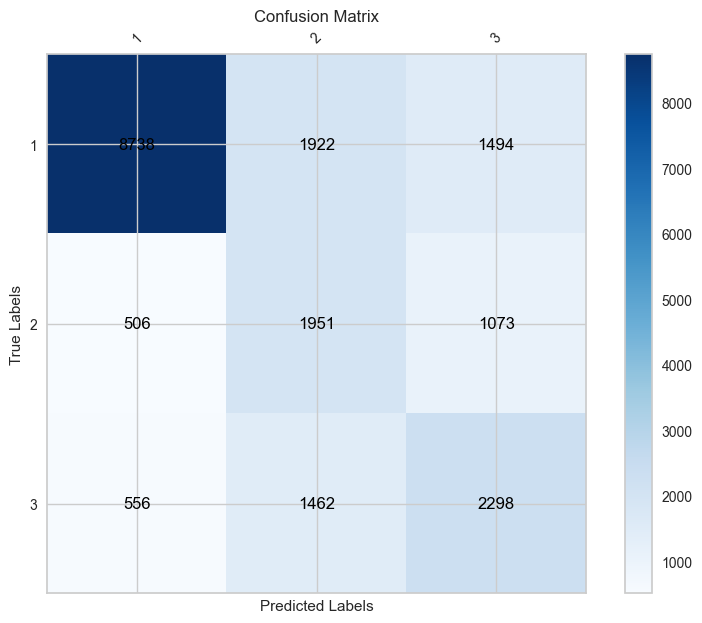

*** Classification Metrics ***
Precision = 0.7083247941424761
Recall = 0.64935
F1 Score = 0.6694634027695244
******************************


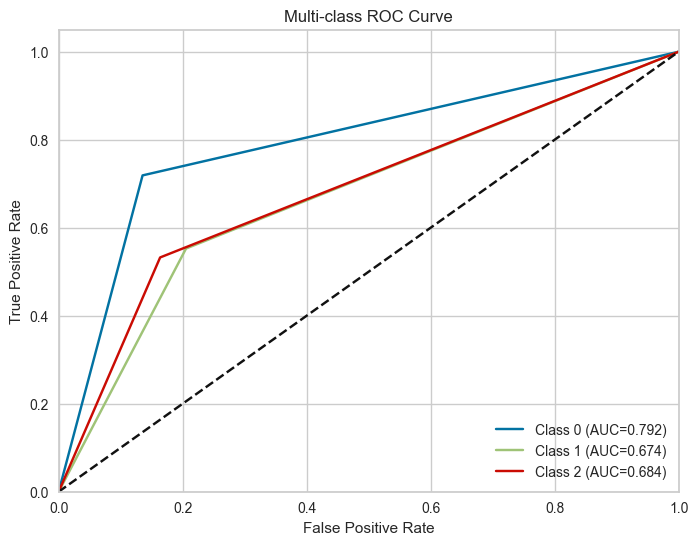

AUC scores for each class: {0: 0.7917923356855775, 1: 0.6736133686279974, 2: 0.6843837299642924}


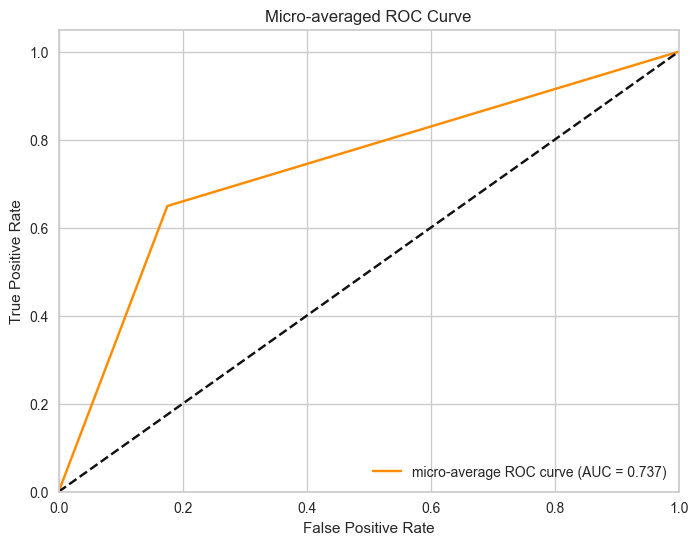

Micro-average ROC AUC: 0.7370125000000001
Mean ROC AUC: 0.7217004835694668


In [55]:
# Prédiction sur les données test et évaluation
y_test_pred_down = logreg_down.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred_down, logreg_down.classes_)

<font color='red'>**Commentaire**</font> 

Le sous-échantillonnage donne de moins bons résultats, nous allons garder le suréchantillonnage et ajouter les pénalités usuelles (Ridge, Lasso, ElasticNet)

## Régression logistique + pénalité

In [56]:
dict_models_pen = {
    'Logistic Regression (Ridge)': logregRidge,
    'Logistic Regression (Lasso)': logregLasso,
    'Logistic Regression (Elastic Net)': logregElasticNet
}



*** Logistic Regression (Ridge) ***


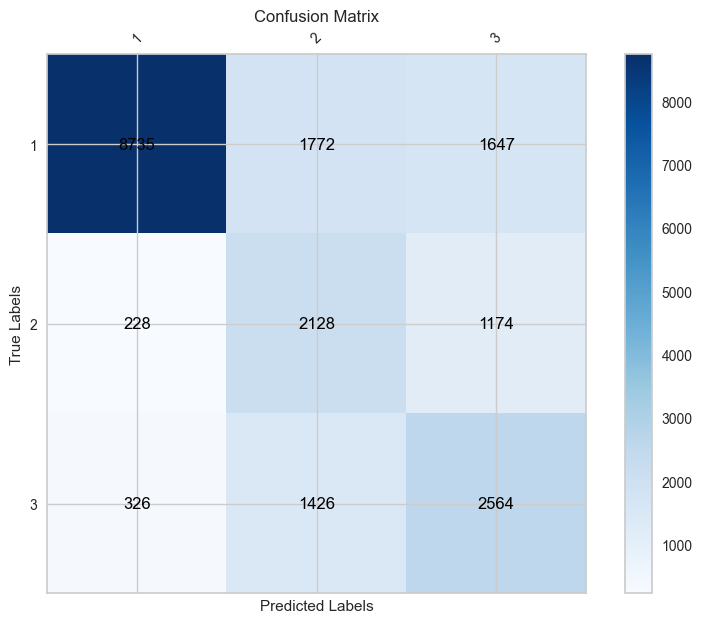

*** Classification Metrics ***
Precision = 0.744727428305034
Recall = 0.67135
F1 Score = 0.6939992481367216
******************************


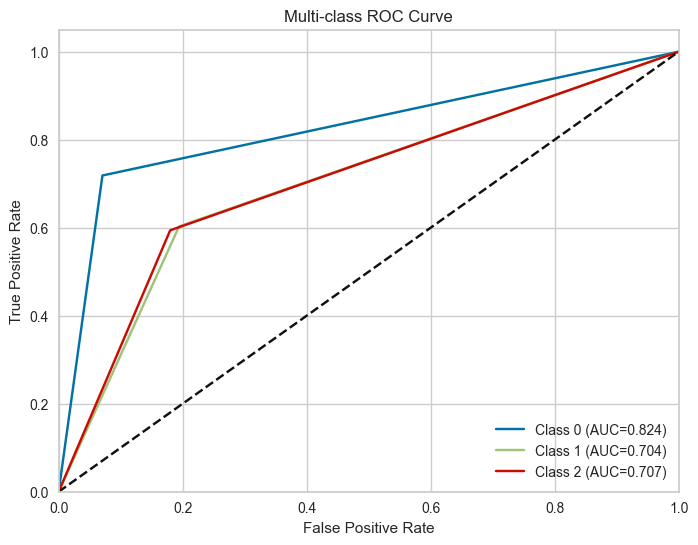

AUC scores for each class: {0: 0.8240421033142058, 1: 0.7043308203945365, 2: 0.7071018758099906}


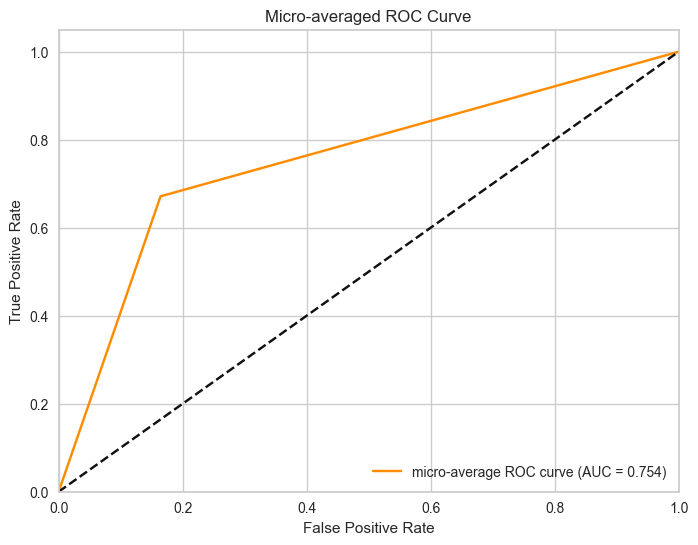

Micro-average ROC AUC: 0.7535124999999999
Mean ROC AUC: 0.7472468248796832


*** Logistic Regression (Lasso) ***


c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


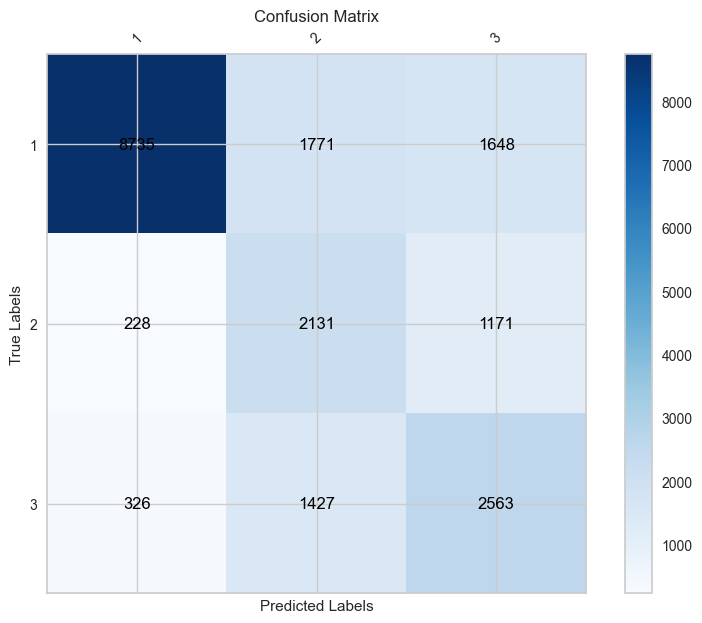

*** Classification Metrics ***
Precision = 0.7448042681511959
Recall = 0.67145
F1 Score = 0.6940808471354332
******************************


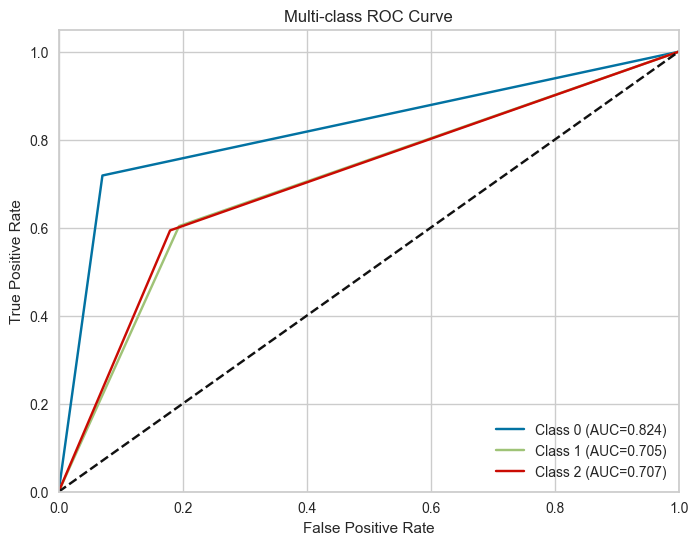

AUC scores for each class: {0: 0.8240421033142058, 1: 0.7047557495730067, 2: 0.7070497870476669}


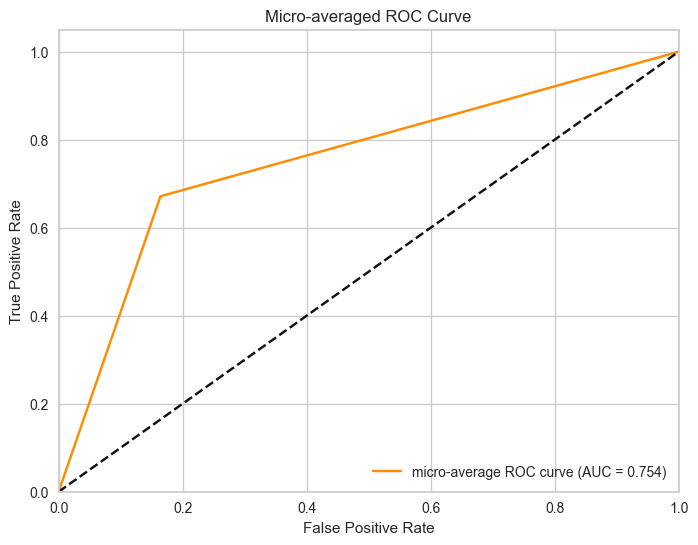

Micro-average ROC AUC: 0.7535875000000001
Mean ROC AUC: 0.7473587849837198


*** Logistic Regression (Elastic Net) ***


c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


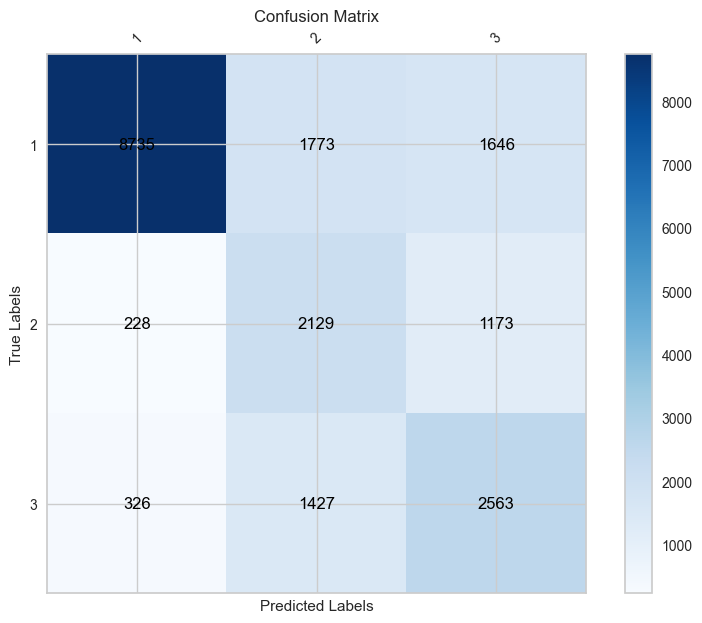

*** Classification Metrics ***
Precision = 0.7447380268301226
Recall = 0.67135
F1 Score = 0.6940011541678297
******************************


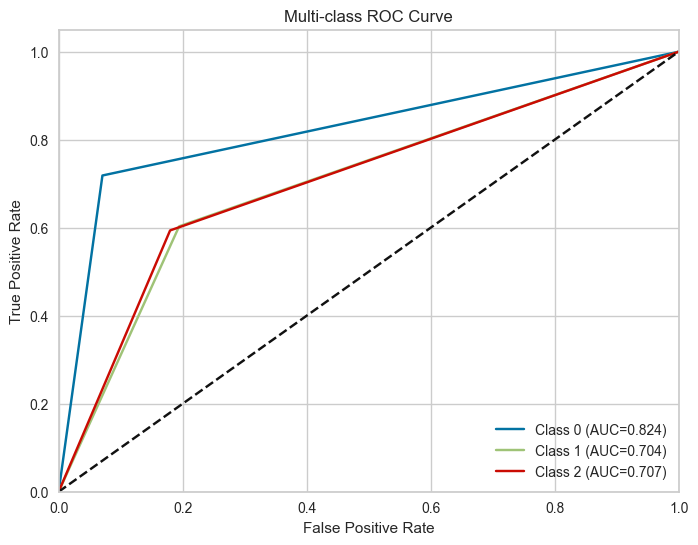

AUC scores for each class: {0: 0.8240421033142058, 1: 0.7044117469998674, 2: 0.7070497870476669}


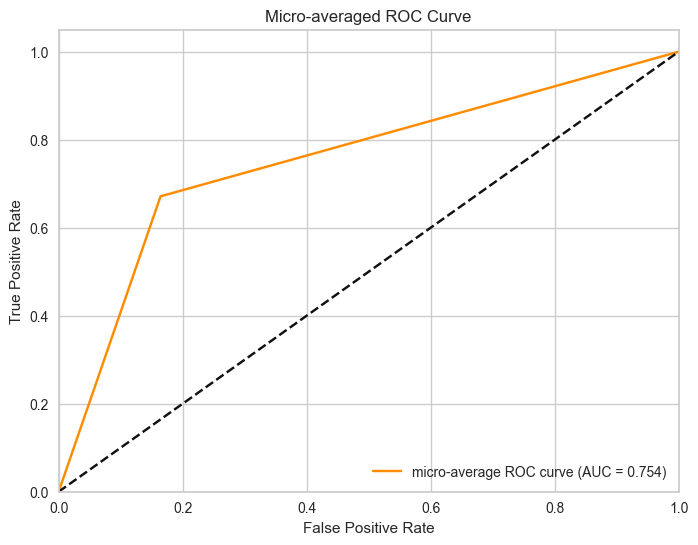

Micro-average ROC AUC: 0.7535124999999999
Mean ROC AUC: 0.7472540343404349


In [57]:
# Evaluate all models
for name, model_up in dict_models_pen.items():
    print('\n')
    print(f"*** {name} ***")
    model_up.fit(X_train_up, y_train_up)
    y_test_pred = model_up.predict(X_test_prep)
    evaluate_model_multiclass(y_test, y_test_pred, model_up.classes_)

### Courbes de validation

In [64]:
def plot_validation_curve(model, X_train, y_train, param_name, param_range, cv=5, scoring='f1_micro', title=None):
    """
    Plot validation curve for a logistic regression model.

    Args:
        model: The logistic regression model to evaluate.
        X_train: Training data.
        y_train: Training labels.
        param_name: Name of the parameter to vary.
        param_range: Range of parameter values to evaluate.
        cv: Number of cross-validation folds.
        scoring: Scoring method to use.
        title: Title of the plot.
    """
    train_scores, val_scores = validation_curve(
        model, 
        X_train, 
        y_train, 
        param_name=param_name, 
        param_range=param_range, 
        cv=cv, 
        scoring=scoring
    )

    plt.figure(figsize=(12, 4))
    plt.plot(param_range, train_scores.mean(axis=1), label='train')
    plt.plot(param_range, val_scores.mean(axis=1), label='validation')
    plt.legend()

    # Find the best C (maximum validation score)
    best_C_idx = np.argmax(val_scores.mean(axis=1))
    best_C = param_range[best_C_idx]

    if title is not None:
        plt.title(f'{title} (Best C: {best_C:.5f})')
    else:
        # plt.title(f'Validation Curve for {model.__class__.__name__}')
        plt.title(f'Validation Curve for Ridge Logistic Regression (Best C: {best_C:.5f})')
    plt.ylabel('Score')
    plt.xlabel(f'{param_name} (Regularization parameter)')
    plt.show()

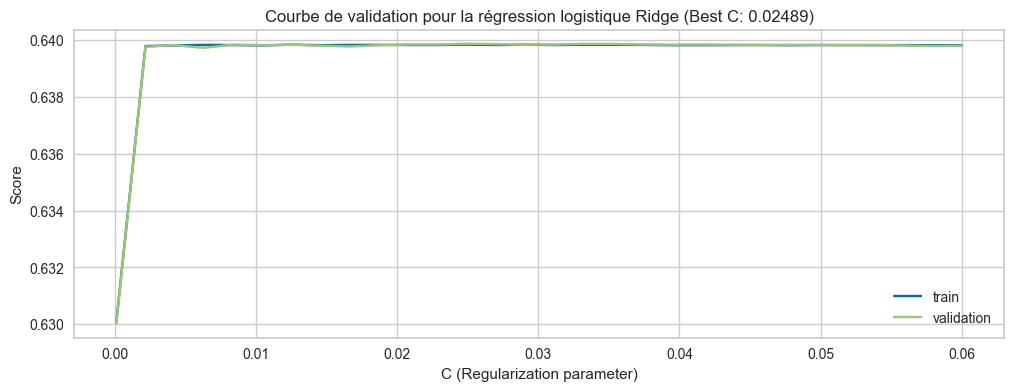

In [65]:
list_hyperparams = np.linspace(0.0001, 0.06, 30)

plot_validation_curve(
    logregRidge,
    X_train_up, 
    y_train_up, 
    param_name='C', 
    param_range=list_hyperparams, 
    cv=5, 
    scoring='f1_micro',
    title="Courbe de validation pour la régression logistique Ridge"
)

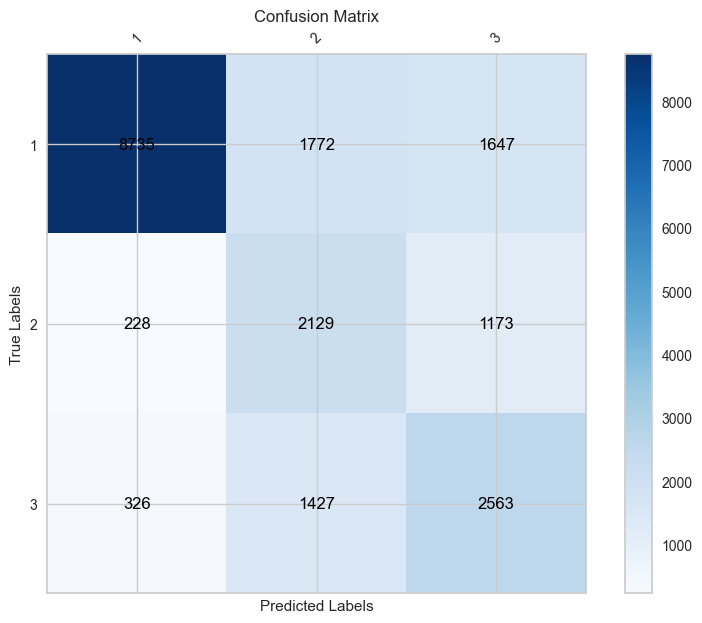

*** Classification Metrics ***
Precision = 0.7447321702735159
Recall = 0.67135
F1 Score = 0.6939989708111278
******************************


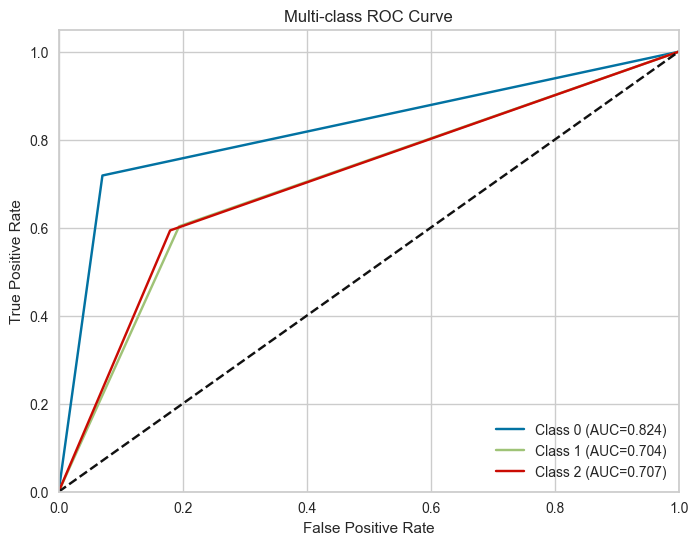

AUC scores for each class: {0: 0.8240421033142058, 1: 0.7044421052269471, 2: 0.7070179074251216}


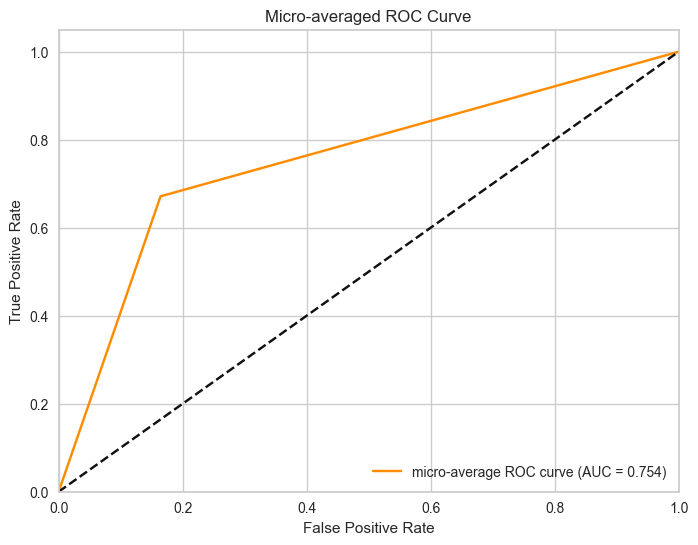

Micro-average ROC AUC: 0.7535124999999999
Mean ROC AUC: 0.7472536539915686


In [66]:
# Entrainer un modèle de régression logistique Ridge avec le meilleur hyperparamètre
logregRidge = LogisticRegression(C=0.02489, penalty='l2', solver='lbfgs', tol=10e-6, random_state=42)
logregRidge.fit(X_train_up, y_train_up)

# Prédire les données test et évaluer le modèle
y_test_pred = logregRidge.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred, logregRidge.classes_)

In [67]:
# Courbe d'apprentissage pour la régression logistique Lasso
plot_validation_curve(
    LogisticRegression(penalty='l1', solver='saga'), 
    X_train_up, 
    y_train_up, 
    param_name='C', 
    param_range=list_hyperparams, 
    cv=5, 
    scoring='f1_micro',
    title="Courbe de validation pour la régression logistique Lasso"
)

c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

KeyboardInterrupt: 

In [ ]:
# Entrainer un modèle de régression logistique Lasso avec le meilleur hyperparamètre
logregLasso = LogisticRegression(C=0.00423, penalty='l1', solver='saga', random_state=42)
logregLasso.fit(X_train_up, y_train_up)

# Prédire les données test et évaluer le modèle
y_test_pred = logregLasso.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred, logregLasso.classes_)

_________

In [64]:
def plot_coefficients(model, feature_names, top_features=10, class_index=0):
    """
    Plot the model coefficients for a logistic regression model.
    
    Parameters:
    model : LogisticRegression
        Trained logistic regression model.
    feature_names : list
        List of feature names.
    top_features : int, default=10
        Number of top features to display.
    class_index : int, default=0
        Index of the class for which coefficients should be displayed.
    """
    # Select coefficients for the specified class
    coef = model.coef_[class_index]
    feature_names = np.array(feature_names)
    
    # Debug statements
    print(f"Total number of features: {len(feature_names)}")
    print(f"Number of coefficients: {len(coef)}")
    
    # Ensure that top_features does not exceed half the number of features
    if 2 * top_features > len(feature_names):
        top_features = len(feature_names) // 2
        print(f"Adjusted top_features to: {top_features}")
    
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # More debug statements
    print(f"Top positive coefficients indices: {top_positive_coefficients}")
    print(f"Top negative coefficients indices: {top_negative_coefficients}")
    print(f"Top coefficients indices: {top_coefficients}")
    
    # Create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    plt.xticks(np.arange(2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.xlabel("Feature")
    plt.ylabel("Coefficient")
    plt.title("Top {} Feature Coefficients for Class {}".format(2 * top_features, class_index))
    plt.show()


Total number of features: 22
Number of coefficients: 22
Top positive coefficients indices: [ 5 15  2 14 10 19 16 20  6 11]
Top negative coefficients indices: [18  9 17  1 13  7 12  8  0 21]
Top coefficients indices: [18  9 17  1 13  7 12  8  0 21  5 15  2 14 10 19 16 20  6 11]


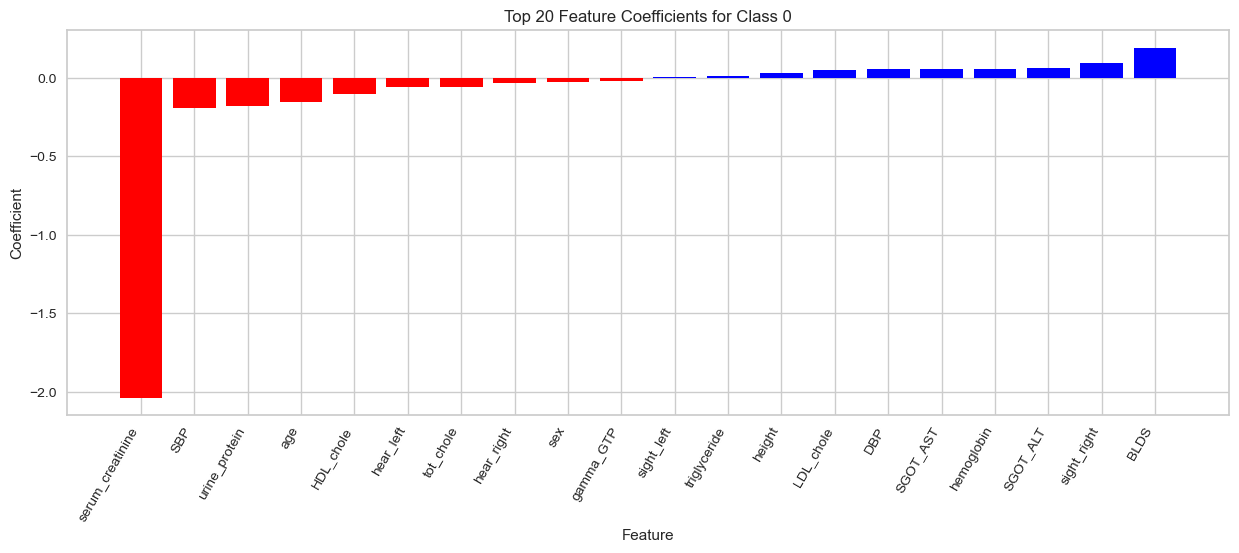

In [144]:
plot_coefficients(logreg, X.columns.to_list(), top_features=10)